# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'2.4.1'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305965  [    0/60000]
loss: 2.290425  [ 6400/60000]
loss: 2.267804  [12800/60000]
loss: 2.258890  [19200/60000]
loss: 2.242018  [25600/60000]
loss: 2.227979  [32000/60000]
loss: 2.224949  [38400/60000]
loss: 2.202474  [44800/60000]
loss: 2.202645  [51200/60000]
loss: 2.162061  [57600/60000]
Test Error: 
 Accuracy: 48.4%, Avg loss: 2.152486 

Epoch 2
-------------------------------
loss: 2.169192  [    0/60000]
loss: 2.153212  [ 6400/60000]
loss: 2.091874  [12800/60000]
loss: 2.104410  [19200/60000]
loss: 2.051557  [25600/60000]
loss: 2.011866  [32000/60000]
loss: 2.022695  [38400/60000]
loss: 1.954537  [44800/60000]
loss: 1.964607  [51200/60000]
loss: 1.880680  [57600/60000]
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.874855 

Epoch 3
-------------------------------
loss: 1.913573  [    0/60000]
loss: 1.878469  [ 6400/60000]
loss: 1.755343  [12800/60000]
loss: 1.790503  [19200/60000]
loss: 1.687827  [25600/60000]
loss: 1.649829  [32000/600

### Save Model State Dict
This is the [currently recommended save format](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [11]:
torch.save(model.state_dict(), "model_weights.pt")
print("Saved PyTorch Model State to model_weights.pt")

Saved PyTorch Model State to model_weights.pt


### Save Entire Model
This saves the entire model using python pickle, but has the [following disadvantage](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model):
> The serialized data is bound to the specific classes and the exact directory structure used when the model is saved... Because of this, your code can break in various ways when used in other projects or after refactors.

In [12]:
torch.save(model, "model.pt")

### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python).  However, this currently doesn't work with spark, which uses pickle serialization.

In [13]:
scripted = torch.jit.script(model)

In [14]:
scripted.save("model.ts")

### Load Model State

In [15]:
model_from_state = NeuralNetwork()
model_from_state.load_state_dict(torch.load("model_weights.pt")) # Load model weights to CPU by default.

/tmp/ipykernel_763809/3376204427.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_from_state.load_state_dict(torch.load("model_weights.pt")) # Load model weights to

<All keys matched successfully>

In [16]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Model

In [17]:
# Load model to original device (GPU) and move to CPU. 
new_model = torch.load("model.pt") 
new_model.to("cpu") 

/tmp/ipykernel_763809/2207636407.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model = torch.load("model.pt")


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [18]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [19]:
# Load model to original device (GPU) and move to CPU. 
ts_model = torch.jit.load("model.ts")
ts_model.to("cpu")

RecursiveScriptModule(
  original_name=NeuralNetwork
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (linear_relu_stack): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [20]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = ts_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## PySpark

### Convert numpy dataset to Pandas DataFrame

In [21]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

In [22]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [23]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [24]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [25]:
%%time
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

CPU times: user 289 ms, sys: 112 ms, total: 401 ms
Wall time: 414 ms


,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
### Create Spark DataFrame from Pandas DataFrame

In [27]:
num_threads = 6

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "8g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/17 16:38:43 WARN Utils: Your hostname, dgx2h0194.spark.sjc4.nvmetal.net resolves to a loopback address: 127.0.1.1; using 10.150.30.2 instead (on interface enp134s0f0np0)
24/09/17 16:38:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/17 16:38:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/17 16:38:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [28]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema)

CPU times: user 421 ms, sys: 84.2 ms, total: 506 ms
Wall time: 4.75 s


In [29]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [30]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema)

CPU times: user 253 ms, sys: 83.8 ms, total: 337 ms
Wall time: 3.92 s


### Save the test dataset as parquet files

In [31]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_1")

24/09/17 16:38:55 WARN TaskSetManager: Stage 0 contains a task of very large size (5369 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 1.39 ms, sys: 4.06 ms, total: 5.45 ms
Wall time: 3.89 s


In [32]:
%%time
df784.write.mode("overwrite").parquet("fashion_mnist_784")

24/09/17 16:38:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/09/17 16:38:59 WARN TaskSetManager: Stage 1 contains a task of very large size (10457 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 8.87 ms, sys: 0 ns, total: 8.87 ms
Wall time: 3.14 s


### Check arrow memory configuration

In [33]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

## Inference using Spark DL API

### 1 columns of 784 float

In [34]:
import os
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [35]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [36]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [37]:
# get absolute path to model
model_dir = "{}/model.ts".format(os.getcwd())

In [38]:
def predict_batch_fn():
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using {} device".format(device))
    model = torch.jit.load(model_dir)
    model.to(device)
    
    def predict(inputs: np.ndarray):
        torch_inputs = torch.from_numpy(inputs).to(device)
        outputs = model(torch_inputs)
        return outputs.detach().cpu().numpy()
    
    return predict

In [39]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [40]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

Using cuda device                                                   (0 + 6) / 6]
Using cuda device
Using cuda device
Using cuda device
Using cuda device
Using cuda device


CPU times: user 414 ms, sys: 185 ms, total: 599 ms
Wall time: 9.34 s


In [41]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 555 ms, sys: 457 ms, total: 1.01 s
Wall time: 2.91 s


In [42]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 1.09 s, sys: 851 ms, total: 1.94 s
Wall time: 3.57 s


### Check predictions

In [43]:
predictions = preds[0].preds
img = preds[0].data

In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
img = np.array(img).reshape(28,28)

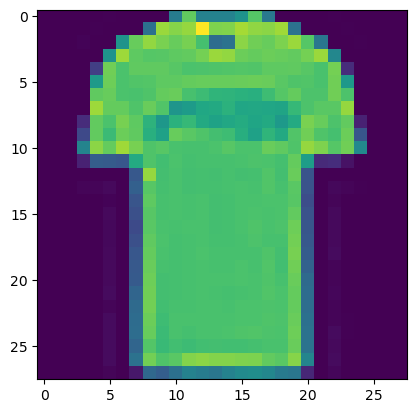

In [46]:
plt.figure()
plt.imshow(img)
plt.show()

In [47]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[3.7672526836395264, 1.306404948234558, 1.4655091762542725, 2.3206827640533447, 1.6551650762557983, -3.0425524711608887, 2.236126184463501, -4.787160396575928, -1.205475926399231, -3.3156495094299316]
predicted label: T-shirt/top


### 784 columns of float

In [48]:
df = spark.read.parquet("fashion_mnist_784")
len(df.columns)

784

In [49]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 1.53 s, sys: 753 ms, total: 2.28 s
Wall time: 12.1 s


In [50]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 798 ms, sys: 364 ms, total: 1.16 s
Wall time: 5.69 s


### Check predictions

In [51]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [52]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [53]:
import matplotlib.pyplot as plt
import numpy as np

In [54]:
img = np.array(img).reshape(28,28)

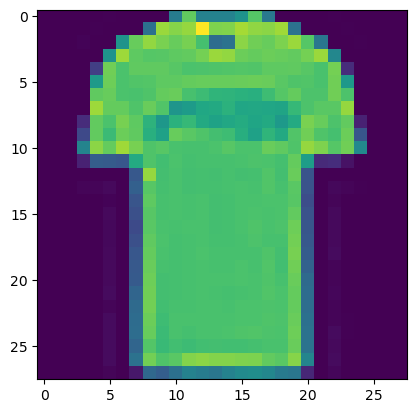

In [55]:
plt.figure()
plt.imshow(img)
plt.show()

In [56]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[ 3.7672532  1.3064048  1.465509   2.3206825  1.6551652 -3.0425525
  2.2361262 -4.7871604 -1.205476  -3.3156502]
predicted label: T-shirt/top


### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [57]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [58]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/fashion_mnist/1
cp model.ts models/fashion_mnist/1/model.pt

# add config.pbtxt
cp models_config/fashion_mnist/config.pbtxt models/fashion_mnist/config.pbtxt

#### Start Triton Server on each executor

In [59]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

>>>> starting triton: 7911421c6023                                  (0 + 1) / 1]


[True]

#### Run inference

In [60]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [61]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [62]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [63]:
mnist = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="fashion_mnist"),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=1024)

In [64]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

/tmp/ipykernel_763809/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_763809/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_763809/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_763809/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_763809/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
/tmp/ipykernel_763809/3110230631.py:6: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


CPU times: user 392 ms, sys: 146 ms, total: 537 ms
Wall time: 3.62 s


In [65]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 1.2 s, sys: 674 ms, total: 1.87 s
Wall time: 3.74 s


In [66]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 480 ms, sys: 163 ms, total: 643 ms
Wall time: 2.68 s


#### Stop Triton Server on each executor

In [67]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

>>>> stopping containers: ['7911421c6023']


[True]

In [68]:
spark.stop()